In [1]:
OUTDATED_IGNORE=1

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import os, pickle
import pingouin as pg

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [27]:
df = pd.read_csv('../DerivedData/cohortA_subjects_clinical.csv', index_col=0)

with open('../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)
df = df[df.subject_id.isin(cohorts['A'])]

In [28]:
df = df[df.PMA_scan < 38]
print('Number of subjects <38w PMA: {}'.format(len(df)))

Number of subjects <38w PMA: 42


### Plot the distribution of FA

In [29]:
## median FA regions 
diff = pd.read_csv('../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

new_df = df.copy()
new_df = pd.merge(new_df, diff[FA_cols], on=['subject_id'])

FA_cols.extend(['PMA_scan'])
inX = new_df[FA_cols].values

In [30]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color='darkgray')
    plt.setp(bp['caps'], color='darkgray')
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color='darkgray', alpha=0.5)
    
scheme = pd.read_csv('../SourceData/atlas_labelling_scheme.csv')
lbs = [name.split('_')[1] for name in FA_cols[:-2]]
names = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]

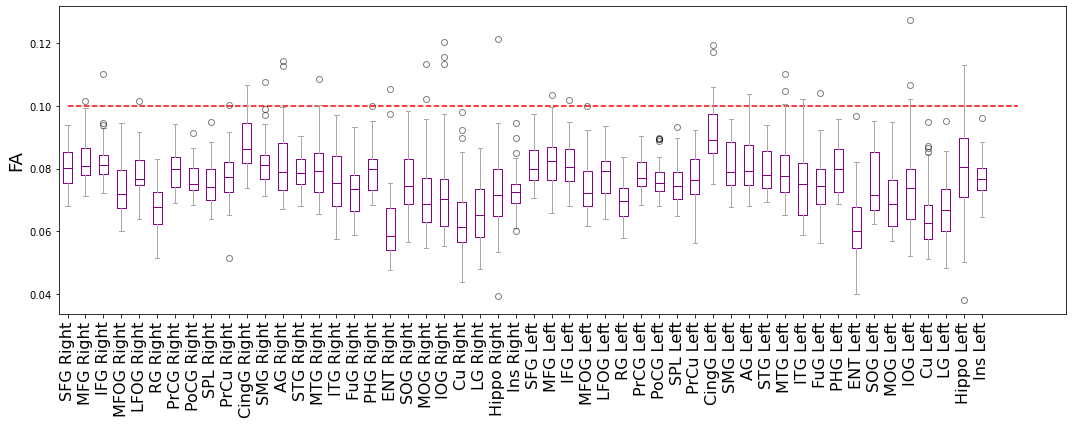

In [31]:
fig, axs = plt.subplots(1,1,figsize=(15,6))

for idx in FA_cols[:-2]:
    new_df[idx].fillna(new_df[idx].median(), inplace=True)

bpl = axs.boxplot([ new_df[idx].values for idx in FA_cols[:-2]], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')

#bpl = axs[1].boxplot([ outX_res[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
#            labels=names, )
#set_box_color(bpl, 'darkmagenta')

#bpl = axs[2].boxplot([ outX_res_40[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
#            labels=names, )
#set_box_color(bpl, 'darkmagenta')


#for ax, label in zip(axs, ['FA', 'residual FA', 'FA (TEA)']):
for ax, label in zip([axs], ['FA']):
    #axs[0].set_xticks( fontsize=14)
    ax.xaxis.set_tick_params(labelrotation=90, labelsize=16)
    ax.set_ylabel(label, fontsize=18 )

plt.hlines(0.1,0,len(names)+1, linestyles='--', color='red')

plt.tight_layout()
plt.savefig('../Results/figures/R2_review_FA_below38.png', dpi=500, facecolor='white', transparent=False)
plt.show()

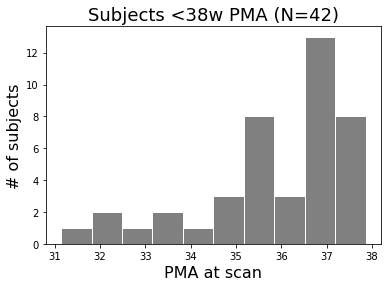

In [68]:
plt.hist(df.PMA_scan.values,  ec="white", fc="grey", )
plt.xlabel('PMA at scan', fontsize=16)
plt.ylabel('# of subjects', fontsize=16)
plt.title('Subjects <38w PMA (N={})'.format(len(df)), fontsize=18)
plt.show()

## Preparation for training of LOOCV 

In [32]:
df[['subject_id', 'session_id']].to_csv('../DerivedData/subjects_below_38w.csv', header=None, index=False )

In [16]:
a = pd.read_csv('../DerivedData/subjects_below_38w.csv', names=['subject_id', 'session_id'])

In [33]:
## ages
#glob = pd.read_csv('../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
#df = pd.merge(df, glob[['subject_id', 'Cognitive Score', 'Language Score', 'Motor Score']], on=['subject_id'])  

In [36]:
noise_volts = np.random.normal(0, 1, len(df))


In [37]:
noise_volts

array([-0.2996994 , -1.54810655, -1.53098034,  1.83690659, -0.61793504,
        0.26898667, -0.01299872,  0.63489508, -0.67726562, -0.00684136,
       -2.9160839 , -1.41598143,  0.23741628, -1.11444129, -0.49150487,
        0.24780467, -0.14463713,  1.49085956, -0.31205493,  0.34748115,
        1.26472416, -0.30045332, -0.49321432,  1.51976961,  0.00971055,
        0.00316572,  0.09603841,  0.63189304,  1.30622474, -0.60812441,
        0.47583469,  0.28390393, -2.42344096, -0.64879327,  1.69062288,
        0.4440828 , -0.23415236,  1.57110206, -0.27566277, -1.01291053,
        0.17211711,  1.3453336 ])

In [54]:
for score in ['Cognitive Score', 'Language Score', 'Motor Score']:
    out = []
    for i in range(100):
        
    
        y = np.empty_like(df[score].values)
        y[:] = np.mean(df[score].values)
    
        noise_volts = np.random.normal(0, 0.5, len(df))
        y = y + noise_volts
        cor = pg.corr(df[score].values, y)
        out.append(cor['r'].values[0])
    print(score, np.mean(out), np.std(out))
    
    #print('{}: rho {}, pval {}'.format(score, cor['r'].values, cor['p-val'].values))


Cognitive Score 0.017934017411348063 0.16556386337263143
Language Score -0.005284849560996727 0.1459816763851322
Motor Score -0.03033713386697532 0.15523368687221165


In [ ]:
df = pd.read_csv('../Results/predictions/AUC_categorical.csv')

rho (std), pval (std), mae (std), r2 (std), rho, rho_p, mae, mae_p

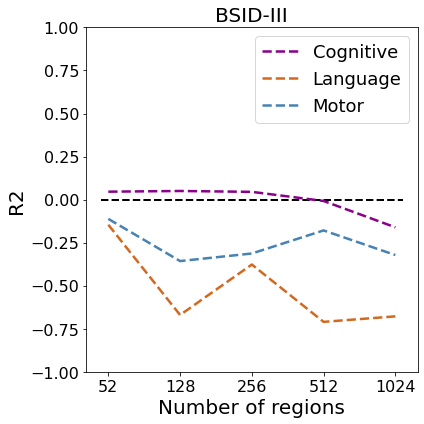

In [80]:
segms = ['Segmentation 52', 'Random 128', 'Random 256', 'Random 512', 'Random 1024']

R2_cog = np.array([0.046,0.050,0.045,-0.008,-0.161])
R2_lan = np.array([-0.146,-0.670,-0.377,-0.710,-0.678])
R2_mot = np.array([-0.112,-0.357,-0.313,-0.179,-0.322])



fix, axs = plt.subplots(1,1, figsize=(6,6), sharey=False)
colors = ['darkmagenta', 'chocolate', 'steelblue', 'chartreuse', 'lightcoral']
colors = ['darkmagenta', 'chocolate', 'steelblue']
x =range(len(segms))
#y1= R2+ (1.96*std)
#y2= R2- (1.96*std)

for score, color, name in zip([R2_cog,R2_lan,R2_mot ], colors, ['Cognitive', 'Language', 'Motor']):
    
    axs.plot(x,score, color=color, linestyle='--', linewidth=2.5, label=name)
    #axs.fill_between(x, y1, y2, color='darkmagenta',  linestyle='--', alpha=0.1)
        
axs.set_ylim(-1, 1)
plt.title('BSID-III', fontsize =20)
plt.hlines(0.0,-.1,4.1, linestyles='dashed', colors='black', linewidth=2)
plt.ylabel('R2', fontsize=20)
plt.xlabel('Number of regions', fontsize=20)
axs.set_xticks(ticks=x)
axs.set_xticklabels([segm.split(' ')[1] for segm in segms], size=16)
axs.tick_params(axis='both', which='major', labelsize=16)
    
#plt.legend(loc='center right', bbox_to_anchor=(0.5, -0.4), fontsize=18)
plt.legend(  fontsize=18)
plt.tight_layout()
plt.show()


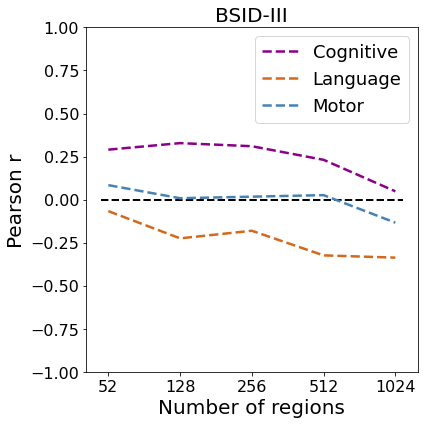

In [82]:
segms = ['Segmentation 52', 'Random 128', 'Random 256', 'Random 512', 'Random 1024']

R2_cog = np.array([ 0.290,0.328,0.310,0.231,0.048,
])
R2_lan = np.array([ -0.067,-0.225,-0.181,-0.324,-0.337,
])
R2_mot = np.array([ 0.084,0.008, 0.017,0.026,-0.134,
])



fix, axs = plt.subplots(1,1, figsize=(6,6), sharey=False)
colors = ['darkmagenta', 'chocolate', 'steelblue', 'chartreuse', 'lightcoral']
colors = ['darkmagenta', 'chocolate', 'steelblue']
x =range(len(segms))
#y1= R2+ (1.96*std)
#y2= R2- (1.96*std)

for score, color, name in zip([R2_cog,R2_lan,R2_mot ], colors, ['Cognitive', 'Language', 'Motor']):
    
    axs.plot(x,score, color=color, linestyle='--', linewidth=2.5, label=name)
    #axs.fill_between(x, y1, y2, color='darkmagenta',  linestyle='--', alpha=0.1)
        
axs.set_ylim(-1, 1)
plt.title('BSID-III', fontsize =20)
plt.hlines(0.0,-.1,4.1, linestyles='dashed', colors='black', linewidth=2)
plt.ylabel('Pearson r', fontsize=20)
plt.xlabel('Number of regions', fontsize=20)
axs.set_xticks(ticks=x)
axs.set_xticklabels([segm.split(' ')[1] for segm in segms], size=16)
axs.tick_params(axis='both', which='major', labelsize=16)
    
#plt.legend(loc='center right', bbox_to_anchor=(0.5, -0.4), fontsize=18)
plt.legend(  fontsize=18)
plt.tight_layout()
plt.show()
